# Imports

In [1]:
import polars as pl
import glob
import pyarrow as pa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from tqdm import tqdm
import gc
import heapq

In [2]:
sns.set_style("darkgrid")

# 1. Loading data

In [3]:
animes_data = pl.read_csv('../data/anime.csv')
ratings_data = pl.read_csv('../data/rating.csv')

In [4]:
animes_data

anime_id,name,genre,type,episodes,rating,members
i64,str,str,str,str,f64,i64
32281,"""Kimi no Na wa.""","""Drama, Romance, School, Supern…","""Movie""","""1""",9.37,200630
5114,"""Fullmetal Alchemist: Brotherho…","""Action, Adventure, Drama, Fant…","""TV""","""64""",9.26,793665
28977,"""Gintama°""","""Action, Comedy, Historical, Pa…","""TV""","""51""",9.25,114262
9253,"""Steins;Gate""","""Sci-Fi, Thriller""","""TV""","""24""",9.17,673572
9969,"""Gintama&#039;""","""Action, Comedy, Historical, Pa…","""TV""","""51""",9.16,151266
…,…,…,…,…,…,…
9316,"""Toushindai My Lover: Minami ta…","""Hentai""","""OVA""","""1""",4.15,211
5543,"""Under World""","""Hentai""","""OVA""","""1""",4.28,183
5621,"""Violence Gekiga David no Hoshi""","""Hentai""","""OVA""","""4""",4.88,219


In [5]:
ratings_data

user_id,anime_id,rating
i64,i64,i64
1,20,-1
1,24,-1
1,79,-1
1,226,-1
1,241,-1
…,…,…
73515,16512,7
73515,17187,9
73515,22145,10


# 2. Exploratory Data Analysis

In [6]:
vc = ratings_data['rating'].value_counts(sort = True)

print(f'Самые популярные оценки')
print('=' * 50)
print(*vc.columns)
for row in vc.to_dicts():
        print(f'{row['rating']:5d} {row['count']:5d} ')

Самые популярные оценки
rating count
    8 1646019 
   -1 1476496 
    7 1375287 
    9 1254096 
   10 955715 
    6 637775 
    5 282806 
    4 104291 
    3 41453 
    2 23150 
    1 16649 


In [7]:
 top_animes = animes_data.sort('members', descending = True)[:10]
 top_animes 

anime_id,name,genre,type,episodes,rating,members
i64,str,str,str,str,f64,i64
1535,"""Death Note""","""Mystery, Police, Psychological…","""TV""","""37""",8.71,1013917
16498,"""Shingeki no Kyojin""","""Action, Drama, Fantasy, Shoune…","""TV""","""25""",8.54,896229
11757,"""Sword Art Online""","""Action, Adventure, Fantasy, Ga…","""TV""","""25""",7.83,893100
5114,"""Fullmetal Alchemist: Brotherho…","""Action, Adventure, Drama, Fant…","""TV""","""64""",9.26,793665
6547,"""Angel Beats!""","""Action, Comedy, Drama, School,…","""TV""","""13""",8.39,717796
1575,"""Code Geass: Hangyaku no Lelouc…","""Action, Mecha, Military, Schoo…","""TV""","""25""",8.83,715151
20,"""Naruto""","""Action, Comedy, Martial Arts, …","""TV""","""220""",7.81,683297
9253,"""Steins;Gate""","""Sci-Fi, Thriller""","""TV""","""24""",9.17,673572
10620,"""Mirai Nikki (TV)""","""Action, Mystery, Psychological…","""TV""","""26""",8.07,657190


Посмотрим на топ  юзеров по кол-ву оценок

In [8]:
counts_rated_user_neg = (
    ratings_data
    .group_by('user_id')          # группируем по колонке
    .agg(pl.len().alias('count')))
print(f'Топ по юзерам сразу')
print(counts_rated_user_neg.sort('count', descending = True)[:10])

counts_rated_user = (
    ratings_data.filter(ratings_data['rating'] !=  -1)
    .group_by('user_id')          # группируем по колонке
    .agg(pl.len().alias('count')))
print(f'Топ по юзерам сразу(оценка проставлена)')
print(counts_rated_user.sort('count', descending = True)[:10])


counts_rated_user_rating_neg = (
    ratings_data
    .group_by(['user_id', 'rating'])          # группируем по колонке
    .agg(pl.len().alias('count')))
print(f'Топ и по оценке и по юзерам сразу')
print(counts_rated_user_rating_neg.sort('count', descending = True)[:10])

counts_rated_user_rating = (
    ratings_data.filter(ratings_data['rating'] !=  -1)
    .group_by(['user_id', 'rating'])          # группируем по колонке
    .agg(pl.len().alias('count')))
print(f'Топ и по оценке и по юзерам сразу(оценка проставлена)')
print(counts_rated_user_rating.sort('count', descending = True)[:10])

Топ по юзерам сразу
shape: (10, 2)
┌─────────┬───────┐
│ user_id ┆ count │
│ ---     ┆ ---   │
│ i64     ┆ u32   │
╞═════════╪═══════╡
│ 48766   ┆ 10227 │
│ 42635   ┆ 3747  │
│ 53698   ┆ 2905  │
│ 57620   ┆ 2702  │
│ 59643   ┆ 2633  │
│ 51693   ┆ 2622  │
│ 27364   ┆ 2499  │
│ 45659   ┆ 2469  │
│ 7345    ┆ 2429  │
│ 66021   ┆ 2362  │
└─────────┴───────┘
Топ по юзерам сразу(оценка проставлена)
shape: (10, 2)
┌─────────┬───────┐
│ user_id ┆ count │
│ ---     ┆ ---   │
│ i64     ┆ u32   │
╞═════════╪═══════╡
│ 42635   ┆ 3747  │
│ 53698   ┆ 2905  │
│ 57620   ┆ 2689  │
│ 59643   ┆ 2632  │
│ 51693   ┆ 2621  │
│ 45659   ┆ 2462  │
│ 7345    ┆ 2429  │
│ 12431   ┆ 2348  │
│ 65840   ┆ 2215  │
│ 22434   ┆ 1991  │
└─────────┴───────┘
Топ и по оценке и по юзерам сразу
shape: (10, 3)
┌─────────┬────────┬───────┐
│ user_id ┆ rating ┆ count │
│ ---     ┆ ---    ┆ ---   │
│ i64     ┆ i64    ┆ u32   │
╞═════════╪════════╪═══════╡
│ 48766   ┆ -1     ┆ 10227 │
│ 66021   ┆ -1     ┆ 2315  │
│ 40604   ┆ -1    

Посмотрим теперь на среднюю оценку для каждого юзера(с учетом и без учета неоцененных тайтлов) 

In [9]:
mean_rating_neg = (
    ratings_data
    .group_by('user_id')          # группируем по колонке
    .agg([pl.mean('rating').alias('mean_rating'), pl.len().alias('count_rated')]))
print(f'Средняя оценка пользователя(без учета неоцененных)')
print(mean_rating_neg[:10].sample(10))

mean_rating = (
    ratings_data.filter(ratings_data['rating'] !=  -1)
    .group_by('user_id')          # группируем по колонке
    .agg([pl.mean('rating').alias('mean_rating'), pl.len().alias('count_rated')]))
print(f'Средняя оценка пользователя(без учета неоцененных)')
print(mean_rating[:10].sample(10))

Средняя оценка пользователя(без учета неоцененных)
shape: (10, 3)
┌─────────┬─────────────┬─────────────┐
│ user_id ┆ mean_rating ┆ count_rated │
│ ---     ┆ ---         ┆ ---         │
│ i64     ┆ f64         ┆ u32         │
╞═════════╪═════════════╪═════════════╡
│ 3165    ┆ 2.5         ┆ 60          │
│ 7869    ┆ 3.535714    ┆ 224         │
│ 28710   ┆ -0.297619   ┆ 84          │
│ 29237   ┆ 7.882353    ┆ 34          │
│ 35269   ┆ -1.0        ┆ 5           │
│ 17182   ┆ 7.5         ┆ 2           │
│ 23241   ┆ 7.5         ┆ 6           │
│ 61895   ┆ 9.240741    ┆ 54          │
│ 59540   ┆ 7.134454    ┆ 119         │
│ 66989   ┆ 7.150282    ┆ 885         │
└─────────┴─────────────┴─────────────┘
Средняя оценка пользователя(без учета неоцененных)
shape: (10, 3)
┌─────────┬─────────────┬─────────────┐
│ user_id ┆ mean_rating ┆ count_rated │
│ ---     ┆ ---         ┆ ---         │
│ i64     ┆ f64         ┆ u32         │
╞═════════╪═════════════╪═════════════╡
│ 19290   ┆ 7.193878    ┆ 29

[Text(0.5, 1.0, 'Гистограмма частот по рейтингам')]

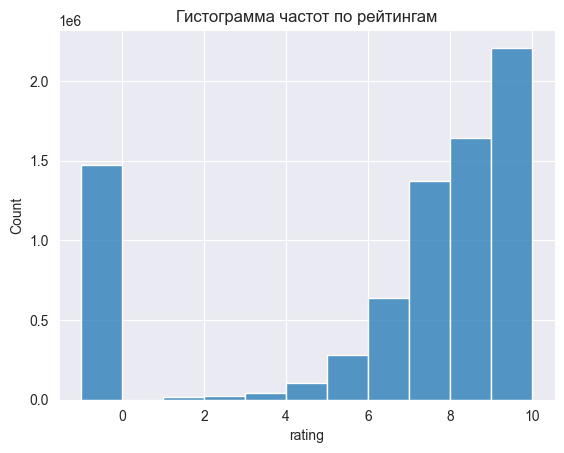

In [10]:
fig, ax = plt.subplots()
sns.histplot(data = ratings_data, x = 'rating', bins=len(ratings_data['rating'].unique()), ax = ax)
ax.set(title = f'Гистограмма частот по рейтингам')

# 2$\dfrac{1}{4}$ Заполенение отсутствующих отзывов

Заполним отстутствие отзывов(-1 в рейтинге) через корень произведения медианной оценки аниме на медианную оценку данного пользователя

In [11]:
unique_users = ratings_data['user_id'].unique()
unique_animes = ratings_data['anime_id'].unique()

non_rated = ratings_data.filter(pl.col('rating') == -1)
rated = ratings_data.filter(pl.col('rating') != -1)

rated_median = rated.group_by(pl.col('anime_id')).agg(pl.median('rating').cast(pl.Int64))

rerated = non_rated.with_columns(
    rating = non_rated.drop(pl.col('rating')).join(rated_median, on = 'anime_id', how = 'left')['rating'].fill_null(strategy = 'mean'),
    
)

ratings_data_reworked = pl.concat([rated, rerated], how = 'vertical')
ratings_data_reworked

user_id,anime_id,rating
i64,i64,i64
1,8074,10
1,11617,10
1,11757,10
1,15451,10
2,11771,10
…,…,…
73515,2385,7
73515,2386,7
73515,2490,7


# 2$\dfrac{1}{2}$ Train/test split

На данный момент просто пройдемся по пользователям и для каждого из них разделим на тест и трейн.

In [12]:
def dummy_train_test_split(ratings_data, frac_test=0.1, seed=42):
    n = len(ratings_data)
    rng = np.random.default_rng(seed)
    perm = rng.permutation(n)
    return ratings_data[perm[int(n *  frac_test):]], ratings_data[perm[: int(n *  frac_test)]]

train_data, test_data = dummy_train_test_split(ratings_data_reworked, frac_test=0.1, seed=42)

# 3. Making User2Item matrix

In [13]:
def create_user2item_matrix(data):
    # отображения id пользователя и аниме в индексы столбцов/строк
    user_map = data.select('user_id').unique().sort('user_id').with_row_index('user_idx')
    anime_map = data.select('anime_id').unique().sort('anime_id').with_row_index('anime_idx')\
    # джойним их к нашей таблице, дабы проще собрать матрицу и проще восстановливать
    data_pre = data.join(user_map, on="user_id", how="left")
    data_new = data_pre.join(anime_map, on="anime_id", how="left")

    # результат отображения 
    row = data_new["user_idx"].to_numpy() 
    col = data_new["anime_idx"].to_numpy()
    data = data_new["rating"].to_numpy()

    # строим разреженную матрицу 
    mat = sp.csr_array(
        (data, (row, col)),
        shape=(
            int(data_new["user_idx"].max()) + 1,
            int(data_new["anime_idx"].max()) + 1
        )
    )

    return mat, data_new

def normalize_columns(user2item_matrix):

    #нормализуем столбцы, дабы, считать расстояния между нормированными товарами
    col_norms = np.sqrt(user2item_matrix.power(2).sum(axis = 0))
    col_norms = np.array(col_norms).ravel()

    col_norms[col_norms == 0] = 1

    return user2item_matrix @ sp.diags(1 / col_norms)

def normalize_rows(user2item_matrix):

    #нормализуем строки, дабы, считать расстояния между нормированными пользователями
    row_norms = np.sqrt(user2item_matrix.power(2).sum(axis = 1))
    row_norms = np.array(row_norms).ravel()

    row_norms[row_norms == 0] = 1

    return sp.diags(1 / row_norms) @ user2item_matrix

## 3.1 Getting matrix

In [14]:
# user2item матрица и колонки для востановления уникальных id пользователя и аниме
user2anime, new_data = create_user2item_matrix(train_data)

In [15]:
user_map = new_data[['user_id', 'user_idx']].unique()
anime_map = new_data[['anime_id', 'anime_idx']].unique()

## 3.2 Normalizing rows and columns

In [16]:
# нормализованные по столбцам и строкам соответственно матрицы

user2anime_normalized_cols = normalize_columns(user2anime)
user2anime_normalized_rows = normalize_rows(user2anime)

# считаем близость с помощью матричных произведений
# ну еслит точнее, то здесь хранится напоминанание о неудачной попытке создания матрицы расстояний
# проблема в том, что онга перестает быть разреженной, но при этом остается огромной, так что по памяти параша

# anime_similarities = user2anime_normalized_rows @ user2anime_normalized_rows.T
# user_similarities = user2anime_normalized_cols.T @ user2anime_normalized_cols

# 4. Using user2item matrix for prediction

## 4.1 item2item and user2user on NearestNeighbours

In [17]:
anime_norm = normalize(user2anime.T, axis = 1)
user_norm = normalize(user2anime, axis = 1)

k = 10

user_nn = NearestNeighbors(n_neighbors = k, metric = 'cosine')
user_nn.fit(user_norm)

anime_nn = NearestNeighbors(n_neighbors = k, metric = 'cosine')
anime_nn.fit(anime_norm)

,n_neighbors,10
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


Какие формулы юзаются для item2item?

Пусть $N_k(u)$ - ближайшие $k$ соседей для пользователя $u$.

Тогда рейтинг для товара  $i$ можно предсказать следующим образом:

$$\hat{r}_{u,i} = \dfrac{\sum\limits_{v \in N(u)}s(u, v)\cdot r_{v,i}}{\sum\limits_{v \in N(u)}|s(u, v)|}$$

In [ ]:
def history_to_vectors(anime_mapping, test_data):
    full_data = test_data.join(anime_mapping, on = 'anime_id', how = 'inner')

    users_with_ratings = full_data['user_id'].unique()
    users_with_ratings = pl.DataFrame(
        {
            'user_id' : users_with_ratings,
            'new_idx' : pl.Series(np.arange(len(users_with_ratings)))
        }
    )

    full_data = full_data.join(users_with_ratings, on = 'user_id', how = 'inner')
    
    csr_test = sp.csr_array(
        (full_data['rating'], (full_data['new_idx'], full_data['anime_idx'])),
        shape = (len(users_with_ratings), len(anime_mapping))
    )

    return csr_test, users_with_ratings
    
    

def recs_nn_user_based(user2item,  nn_model, users_to_predict, k = 10):
    # нормализуем пользователей в матрице и пользователей для предсказания
    users_to_predict = normalize(users_to_predict, axis = 1)
    user2item_normalized_by_users = normalize(user2item, axis = 1)

    # фитим модель на нормализованной матрице
    nn_model.fit(user2item_normalized_by_users, )
    user_distances, user_indices = nn_model.kneighbors(users_to_predict)

    # число пользователей для предсказания и пустой список для хранения рекомендаций для каждого пользователя
    n_users = users_to_predict.shape[0]
    recs = []

    for u_idx in tqdm(range(n_users), desc = 'Перебор по юзерам для построения рекомендаций'):
        # топ соседей и расстояний до них
        neighbors = user_indices[u_idx, :]
        sims = 1 - user_distances[u_idx, :]

        # рейтинги и сумма "похожестей" хранятся в словарях
        pred_ratings = {}
        pred_sim_sums = {}
        for nbr_idx, sim in zip(neighbors, sims):
            #фиксируем нужного соседа(ряд)
            row_start = user2item.indptr[nbr_idx]
            row_end = user2item.indptr[nbr_idx + 1]

            # это все анимешки, просмотренные соседом(с рейтингами)
            items = user2item.indices[row_start:row_end]
            ratings = user2item.data[row_start:row_end]

            for i, r in zip(items, ratings):
                if i not in pred_ratings:
                    pred_ratings[i] = 0.0
                    pred_sim_sums[i] = 0.0
                pred_ratings[i] += sim * r
                pred_sim_sums[i] += abs(sim)
                
        for i in pred_ratings:
            if pred_sim_sums[i] > 0:
                pred_ratings[i] /= pred_sim_sums[i]
            else:
                pred_ratings[i] = -1
                
        top_k = dict(heapq.nlargest(k, pred_ratings.items(), key=lambda x: x[1]))
        recs.append(top_k)

    return recs
            
def recs_nn_anime_based(user2item,  nn_model, users_to_predict, k = 10):
    user2item_normalized_by_animes = normalize(user2item.T, axis = 1)
    nn_model.fit(user2item_normalized_by_animes)
    anime_distances, anime_indices = nn_model.kneighbors(user2item_normalized_by_animes)
    anime_similarities = 1. - anime_distances

    anime_neighbors = {
        i: {nbr: sim for nbr, sim in zip(anime_indices[i, 1:], anime_similarities[i, 1:])}
        for i in range(anime_indices.shape[0])
    }
    
    n_users = users_to_predict.shape[0]

    recs = []
    for user_idx in tqdm(users_to_predict, desc = 'Перебор по юзерам в item2item: '):
        #фиксируем нужного юзера(ряд)
        row_start = user2item.indptr[user_idx]
        row_end = user2item.indptr[user_idx + 1]

        # это все анимешки, просмотренные юзером(с рейтингами)
        items = user2item.indices[row_start:row_end]
        ratings = user2item.data[row_start:row_end]

        user_items = set(items)
        
        candidates = set()
        for item in user_items:
            candidates.update(anime_neighbors[item].keys())
        candidates -= user_items
        
        pred_ratings = {}
        pred_sim_sums = {}

        # цикл по кандидатам
        for candidate in candidates:
            num, den = 0.0, 0.0
            
            # цикл по просмотренным айтемам
            for item, rating in zip(items, ratings):
                sim = anime_neighbors[item].get(candidate, 0.0)
                if sim != 0.0:  # только если есть похожесть
                    num += sim * rating
                    den += abs(sim)
            
            if den > 0:
                pred_ratings[candidate] = num / den
                
        top_k = dict(heapq.nlargest(k, pred_ratings.items(), key=lambda x: x[1]))
        recs.append(top_k)

    return recs
        
    

In [19]:
ratings_data_reworked

user_id,anime_id,rating
i64,i64,i64
1,8074,10
1,11617,10
1,11757,10
1,15451,10
2,11771,10
…,…,…
73515,2385,7
73515,2386,7
73515,2490,7


In [ ]:
hooray_finally_recs = recs_nn_user_based(user2anime, user_nn, user2anime)

In [ ]:
hooray_finally_recs

In [ ]:
hooray_finally_recs_again = recs_nn_anime_based(user2anime, user_nn, user_map['user_idx'])

In [ ]:
hooray_finally_recs_again

## 4.2 item2item and user2user on HNSW

In [ ]:
a = dict(zip([4,5,6],[3,2,1]))
sorted_dict = dict(sorted(a.items(), key=lambda x: x[1], reverse = True))

In [ ]:
top_k = dict(heapq.nlargest(2, a.items(), key=lambda x: x[1]))
top_k